**Author:** Alexandre Ray

**Date:** September 01, 2021

# Authenticate with google drive

First, you have to put the datasets inside your google drive folder and then authenticate it using the code below in order to access the datasets inside the folders and manipulate them in this notebook.

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Install libraries

Some of the libraries are not default. So, you will need to install them manually using the code below:

In [2]:
!pip install fiona
!pip install geojson
!pip install osgeo
!pip install geopandas
!pip install geojsonio
!pip install geoplot
!pip install requests

  Using cached osgeo-0.0.1.tar.gz (1.2 kB)
  ERROR: Failed building wheel for osgeo
  Running setup.py clean for osgeo
Failed to build osgeo
    Running setup.py install for osgeo ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-sz4ccvoj/osgeo_4796a880de5a4ecf94a1a9962b5abda8/setup.py'"'"'; __file__='"'"'/tmp/pip-install-sz4ccvoj/osgeo_4796a880de5a4ecf94a1a9962b5abda8/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setuptools import setup; setup()'"'"');code = f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' install --record /tmp/pip-record-x7_lizep/install-record.txt --single-version-externally-managed --compile --install-headers /usr/local/include/python3.7/osgeo Check the logs for full command output.


# Import libraries

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly
import plotly.offline as plty
plt.rc('axes', labelsize=14)    # fontsize of the x and y labels
pd.set_option('display.max_column', 150)

import fiona
import geojson
import geopandas as gpd
import geojsonio
from IPython.display import HTML
import matplotlib.pyplot as plt

# About the data sources

In this project, I will use two data sources: **IBGE** and **Geosampa**.

### IBGE: 
The Brazilian Institute of Geography and Statistics (Portuguese: Instituto Brasileiro de Geografia e Estatística; IBGE) is the agency responsible for official collection of statistical, geographic, cartographic, geodetic and environmental information in Brazil. IBGE performs a decennial national census; questionnaires account for information such as age, household income, literacy, education, occupation and hygiene levels. 

References:
* [What is IBGE?](https://en.wikipedia.org/wiki/Brazilian_Institute_of_Geography_and_Statistics)
* [Official website](https://www.ibge.gov.br/)

### Geosampa:
The Geosampa Portal is a portal that follows the guidelines of the Strategic Master Plan, bringing together georeferenced data about the city of São Paulo, including about 12 thousand urban facilities, public transport network, geotechnical maps and important data about the population, such as density demographic and social vulnerability.

References:
* [What is Geosampa?](https://gestaourbana.prefeitura.sp.gov.br/noticias/geosampa-veja-a-cidade-de-sao-paulo-em-3d/)
* [Official website](http://geosampa.prefeitura.sp.gov.br/)

In order to understand the data, it is important to define what is **census sector**:

**Census sector:** According with [IBGE](https://www.ibge.gov.br/geociencias/organizacao-do-territorio/estrutura-territorial/26565-malhas-de-setores-censitarios-divisoes-intramunicipais.html?=&t=o-que-e), census sector is the smaller territorial portion used by IBGE to plan and carry out data surveys of the Census and Statistical Surveys, the Census Sector. This corresponds to a section of the national territory, considering the Political-Administrative Division and other territorial structures, which allows for the collection of statistical information within the period determined for collection.

The census sector will be used throughout this notebook.

# Objetives

1. Study socioeconomic aspects versus accessibility to subway stations of the city of São Paulo.
2. Learn how to use and manipulate geolocation data using Python (geopandas and geojson).


*obs: This is a simplification for this work. The data sources provide much more information which could be used in order to made this study.*

# Import datasets

In [4]:
# put your datasets inside this folder
path = 'drive/MyDrive/TAU/notebooks/data'

# -------------------------------------------------------
# IBGE data
# -------------------------------------------------------

# geographic data
sp_state = gpd.read_file(f"{path}/33SEE250GC_SIR.dbf")

# income data
df_income = pd.read_csv(f"{path}/PessoaRenda_SP1.csv", sep=';')

# -------------------------------------------------------
# Geosampa data
# -------------------------------------------------------

# census sector of sp city
sp_city = gpd.read_file(f"{path}/SAD6996_SETOR_CENSITARIO_2010.shp")

# metro station of sp city
sp_city_metro = gpd.read_file(f"{path}/SAD69-96_SHP_estacaometro_point.dbf")

# State of São Paulo

In [5]:
type(sp_state)

geopandas.geodataframe.GeoDataFrame

In [6]:
sp_state.head(3)

ID       CD_GEOCODI    TIPO   CD_GEOCODS NM_SUBDIST CD_GEOCODD  \
0  98237.0  354100005000009  URBANO  35410000500       None  354100005   
1  98232.0  354100005000004  URBANO  35410000500       None  354100005   
2  98230.0  354100005000002  URBANO  35410000500       None  354100005   

     NM_DISTRIT CD_GEOCODM    NM_MUNICIP NM_MICRO                     NM_MESO  \
0  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
1  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   
2  PRAIA GRANDE    3541000  PRAIA GRANDE   SANTOS  METROPOLITANA DE SÃO PAULO   

     CD_GEOCODB  NM_BAIRRO  ID1  \
0  354100005001  Boqueirão    1   
1  354100005001  Boqueirão    2   
2  354100005001  Boqueirão    3   

                                            geometry  
0  POLYGON ((-46.41024 -24.01103, -46.41169 -24.0...  
1  POLYGON ((-46.41606 -24.00245, -46.41598 -24.0...  
2  POLYGON ((-46.41213 -24.00792, -46.41244 -24.0...

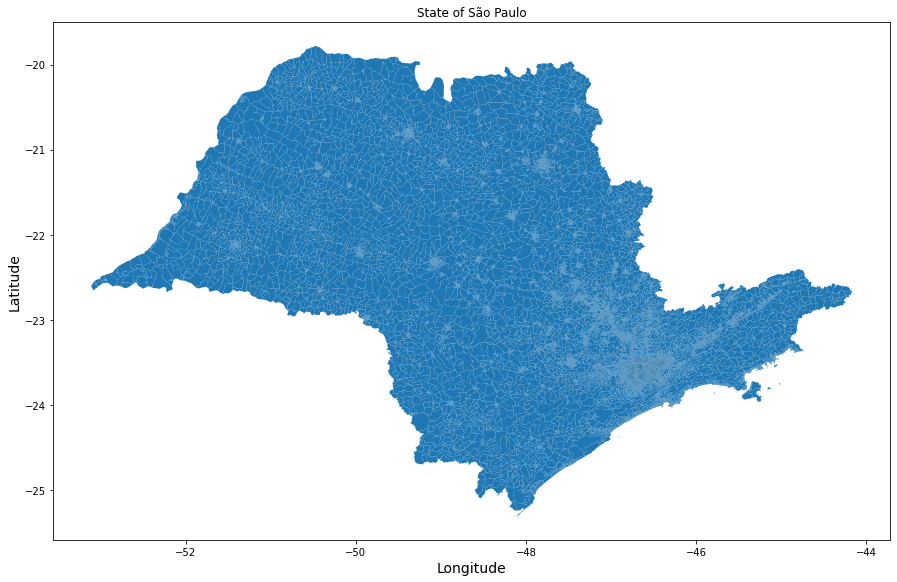

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

sp_state.plot(ax=ax, legend=True)
plt.title("State of São Paulo")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# City of São Paulo

In [8]:
sp_state['is_sp'] = sp_state['NM_MUNICIP'] == 'SÃO PAULO'
sp_state['is_sp'] = sp_state['is_sp'].astype(int)

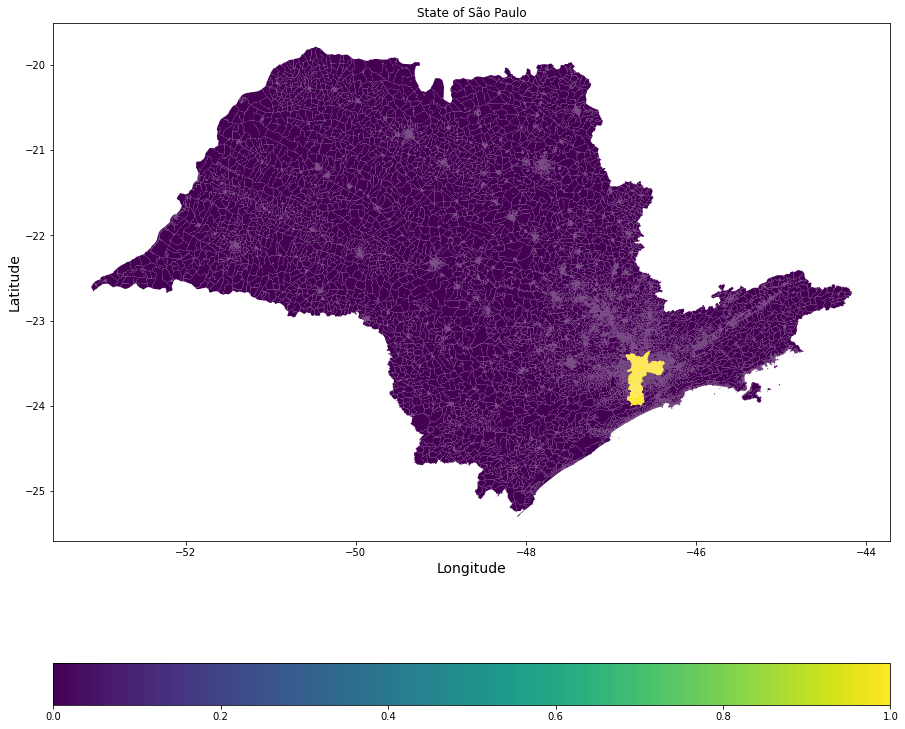

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))

sp_state.plot(column='is_sp', ax=ax, legend=True, 
        legend_kwds={'orientation': 'horizontal'})
plt.title("State of São Paulo")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# São Paulo Metro

In [10]:
sp_city_metro.head()

emt_empres emt_situac emt_linha               emt_nome  \
0      METRO   OPERANDO  VERMELHA   CORINTHIANS-ITAQUERA   
1      METRO   OPERANDO  VERMELHA            ARTUR ALVIM   
2      METRO   OPERANDO  VERMELHA              PATRIARCA   
3      METRO   OPERANDO  VERMELHA  GUILHERMINA-ESPERANÇA   
4      METRO   OPERANDO  VERMELHA           VILA MATILDE   

                         geometry  
0  POINT (349884.430 7395720.764)  
1  POINT (348502.644 7395929.882)  
2  POINT (346777.766 7396920.334)  
3  POINT (345227.021 7397116.638)  
4  POINT (343753.993 7396811.454)

In [11]:
sp_city_metro['emt_nome'].nunique()

84

In [12]:
sp_city_metro['emt_situac'].value_counts()

OPERANDO    93
Name: emt_situac, dtype: int64

São Paulo has 84 operating metro stations. The following plot shows the stations:

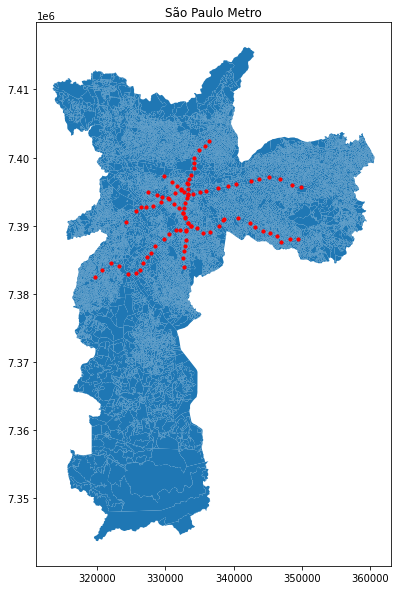

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

base = sp_city.plot(ax=ax, legend=True)
sp_city_metro.geometry.plot(ax=base, marker='o', color='red', markersize=10)
plt.title("São Paulo Metro")
plt.show()

In [14]:
print(f"how many census sector the city of são paulo has? {len(sp_city)}")
print(f"how many metro stations? {len(sp_city_metro)}")
print(f"# census sector X # metro stations? {len(sp_city) * len(sp_city_metro)}")

how many census sector the city of são paulo has? 18953
how many metro stations? 93
# census sector X # metro stations? 1762629


# Distance between regions and metro stations

For each census sector, we calculate the distance between the **centroid** of the census sector and the **nearest metro station**. With this distance, we will investigate futher details about the accessibility of different regions by socieconomic behavior.

The regions are defined as a polygon and the centroid is been used as an approximation as the census sector tends to be a small area of the city (smaller then a district). 

In [15]:
# calculate the centroid of each census sector
sp_city['centroid'] = sp_city.geometry.centroid

In [16]:
# the result is an object POINT. Now, we can calculate the distance between two POINTs
sp_city.centroid.head(1)

0    POINT (313956.205 7410298.593)
dtype: geometry

In [17]:
# metro station (it is also an object POINT)
sp_city_metro.geometry.head(1)

0    POINT (349884.430 7395720.764)
Name: geometry, dtype: geometry

In [18]:
sp_city.head()

geometry  \
0  POLYGON ((313628.771 7410329.633, 313635.166 7...   
1  POLYGON ((313628.771 7410329.633, 313671.875 7...   
2  POLYGON ((313626.089 7410703.311, 313649.891 7...   
3  POLYGON ((314115.028 7411052.848, 314127.886 7...   
4  POLYGON ((317885.162 7410742.053, 317884.480 7...   

                         centroid  
0  POINT (313956.205 7410298.593)  
1  POINT (313593.171 7410155.670)  
2  POINT (314006.409 7410674.474)  
3  POINT (316312.501 7410115.468)  
4  POINT (318043.309 7410564.489)

In [19]:
sp_city_metro.head()

emt_empres emt_situac emt_linha               emt_nome  \
0      METRO   OPERANDO  VERMELHA   CORINTHIANS-ITAQUERA   
1      METRO   OPERANDO  VERMELHA            ARTUR ALVIM   
2      METRO   OPERANDO  VERMELHA              PATRIARCA   
3      METRO   OPERANDO  VERMELHA  GUILHERMINA-ESPERANÇA   
4      METRO   OPERANDO  VERMELHA           VILA MATILDE   

                         geometry  
0  POINT (349884.430 7395720.764)  
1  POINT (348502.644 7395929.882)  
2  POINT (346777.766 7396920.334)  
3  POINT (345227.021 7397116.638)  
4  POINT (343753.993 7396811.454)

In order to accelerate calculations, I'll use just urban areas.

In [20]:
# The following lines can take time to run!

# def calculate_distance(centroid_census_sector):
#   dist = sp_city_metro.geometry.distance(centroid_census_sector)

#   return dist.min()

# for idx, row in sp_city_urban.iterrows():
#   sp_city_urban['nearest_metro'] = sp_city_urban['centroid'].apply(calculate_distance)

# this is calculated before because it takes time to run
#del sp_city_urban
sp_city = pd.read_csv(f"{path}/sf_setor.csv", index_col=0)

sp_city_urban = sp_city.loc[sp_city.TIPO == 'URBANO']

In [21]:
sp_city_urban.head()

ID      AREA_M         CODSETOR    TIPO  POPULACAO  IPVS_V10  \
0    1   311095.19  355030803000062  URBANO        NaN       NaN   
6    7   410829.23  355030861000118  URBANO        NaN       NaN   
8    9  1263124.28  355030861000083  URBANO       20.0       0.0   
9   10   280118.32  355030861000112  URBANO        NaN       NaN   
10  11  1513215.48  355030861000078  URBANO       12.0       0.0   

                                             geometry  \
0   POLYGON ((313628.7709768168 7410329.632962719,...   
6   POLYGON ((319191.7099752288 7412432.592812435,...   
8   POLYGON ((320681.5316965106 7412563.092803963,...   
9   POLYGON ((321962.918756799 7412345.474698704, ...   
10  POLYGON ((323845.8138500933 7411697.682300923,...   

                                       centroid  setor  nearest_metro  
0   POINT (313956.2053629819 7410298.593495445)      1   20384.719766  
6   POINT (319029.3065562922 7410805.343532315)      0   17278.520044  
8   POINT (321341.4878130807 7411880.875878612)      0   16857.042761  
9   POINT (322722.8220911079 7411730.192742853)      0   16070.752726  
10  POINT (323182.8323711662 7411374.346168253)      0   15550.383909

In [22]:
sp_city_urban.nearest_metro.describe(percentiles=[0.05, 0.25, 0.5, 0.75, 0.85, 0.90, 0.95])

count    18228.000000
mean      3885.375454
std       3643.817859
min         27.451046
5%         395.169257
25%       1209.194173
50%       2709.056134
75%       5483.815784
85%       7585.437206
90%       8809.370437
95%      11074.933671
max      28179.256245
Name: nearest_metro, dtype: float64

We see that the smallest distance between a metro station and a census sector is 27 meters and the greatest distance is 28 kilometers.

50% of the regions have access to a metro station within 2.7 kilometers which means about 30 minutes on foot.

## Central vs extreme census sectors considering metro stations

We are going to measure the 5% further and the 5% closer census sector considering the distance between the centroids and the metro stations. After that, we will prepare the data to plot the result using geolocation data and geopandas library.

In [23]:
# 5% census sector more distant of a metro station
more_distant = sp_city_urban.loc[sp_city_urban.nearest_metro > 11074]
more_distant.shape

(912, 10)

In [24]:
# 5% census sector closer to a metro station
closer = sp_city_urban.loc[sp_city_urban.nearest_metro < 395]
closer.shape

(908, 10)

In [25]:
sp_city_urban['census_sector_away'] = sp_city_urban['CODSETOR'].isin(more_distant.CODSETOR.tolist())
sp_city_urban['census_sector_away'] = sp_city_urban['census_sector_away'].astype(int)

sp_city_urban['census_sector_next'] = sp_city_urban['CODSETOR'].isin(closer.CODSETOR.tolist())
sp_city_urban['census_sector_next'] = sp_city_urban['census_sector_next'].astype(int)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [26]:
sp_city_urban['geometry'] = gpd.GeoSeries.from_wkt(sp_city_urban['geometry'])
sp_city_urban = gpd.GeoDataFrame(sp_city_urban, geometry='geometry')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## Census sector near metro station (5% closer - until 395 meters)

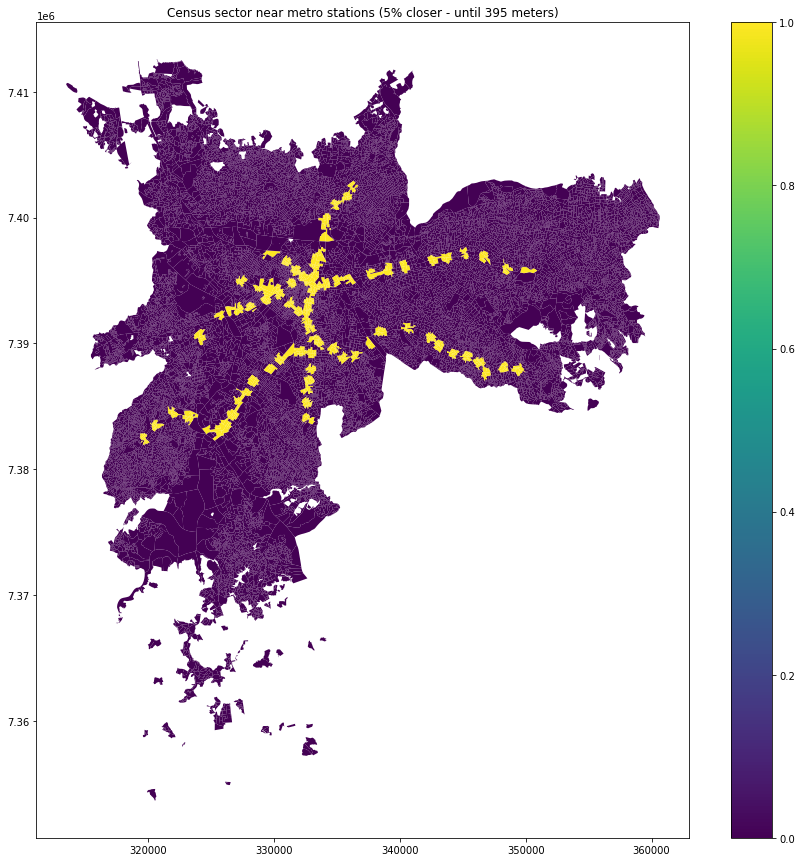

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sp_city_urban.plot(column='census_sector_next', ax=ax, legend=True)
plt.title("Census sector near metro stations (5% closer - until 395 meters)")
plt.show()

## Census sector further metro station (5% further - above 11 kilometers)

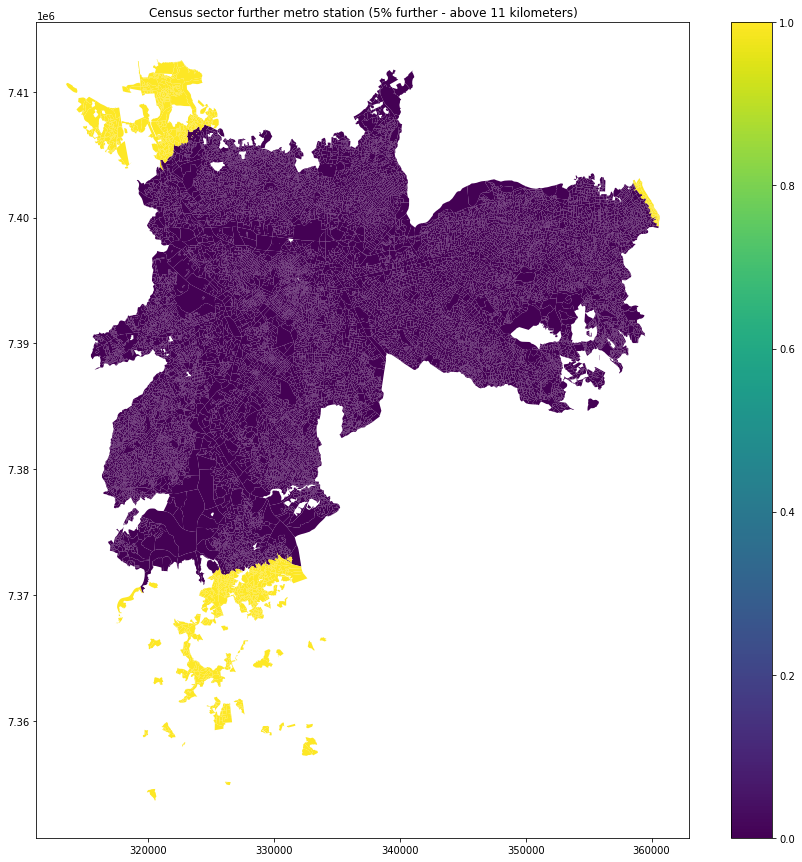

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sp_city_urban.plot(column='census_sector_away', ax=ax, legend=True)
plt.title("Census sector further metro station (5% further - above 11 kilometers)")
plt.show()

We clearly can see the regions further from the metro stations marked with yellow in the plot above. It corresponds to the 5% further census sector of the city of São Paulo. The areas involves extreme south, northwest and east of the city.

## Quartile analysis - darkers regions demonstrates more accessibility to the metro station

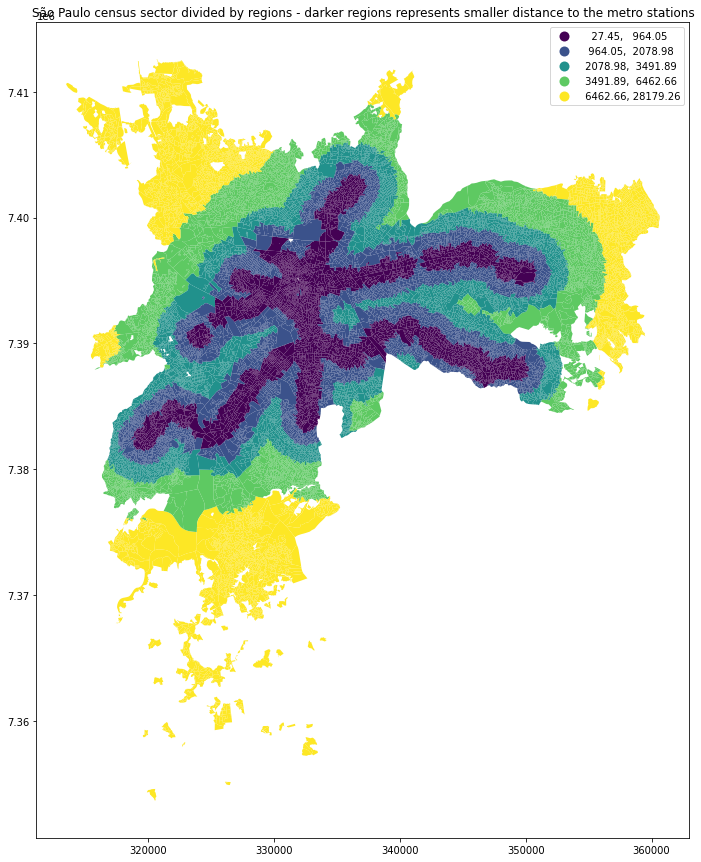

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sp_city_urban.plot(column='nearest_metro', ax=ax, legend=True, scheme='quantiles')
plt.title("São Paulo census sector divided by regions - darker regions represents smaller distance to the metro stations")
plt.show()

# IBGE - income data

Now, we will analyse regions using socioeconomic data collected from IBGE.

The dataset below corresponds to income data for each census sector (key: **CODSETOR**)

The documentation and meaning of the variables can be found in the IBGE [website](ibge.gov.br/estatisticas-novoportal/downloads-estatisticas.html).

In [30]:
df_income.head()

Cod_setor  Situacao_setor V001 V002 V003 V004 V005 V006 V007 V008  \
0  355030801000001               1    2   93  180   92   82   63    9    3   
1  355030801000002               1    6  138  205   85   72   56    4    4   
2  355030801000003               1    1   32  102   46   67   19    5    9   
3  355030801000004               1    2   24  126   56   41   28    4    2   
4  355030801000005               1    3   99  168   81   59   35    5    3   

  V009 V010  V011   V012    V013    V014    V015    V016   V017   V018  \
0    6  210   500  45586  145666  123340  168695  235500  56000  26000   
1    7  233  1300  68975  162678  116432  146600  205800  25300  32000   
2    2  277   200  15420   88264   63472  133006   69300  30000  76000   
3    2  229   350  11570  101151   75650   82890  103600  25500  19000   
4    1  217   650  49985  139175  107740  118035  130700  31000  26500   

     V019 V020 V021    V022 V023 V024 V025 V026 V027 V028 V029 V030 V031 V032  \
0  107000  740  530  908287    0   27   85   47   53   37    7    3    4   78   
1   88000  810  577  847085    2   41  101   50   49   31    4    2    5   79   
2   30000  560  283  505662    0   12   48   26   38   10    4    7    2  117   
3   27000  514  285  446711    0    6   66   35   27   16    3    2    2   92   
4   12000  671  454  615785    1   31   82   54   36   23    3    3    1   79   

  V033   V034   V035   V036    V037    V038   V039   V040   V041 V042 V043  \
0    0  13250  71061  63410  111945  138400  44000  26000  75000  341  263   
1  400  20540  82990  69400  101100  115100  25300  16000  65000  364  285   
2    0   5860  41630  36300   75906   34000  24000  60000  30000  264  147   
3    0   3030  53002  47750   54090   60900  18000  19000  27000  249  157   
4  200  15600  70475  72630   73034   84600  18000  26500  12000  313  234   

     V044 V045 V046 V047 V048 V049 V050 V051 V052 V053 V054 V055   V056  \
0  543066    2   66   95   45   29   26    2    0    2  132  500  32336   
1  495830    4   97  104   35   23   25    0    2    2  154  900  48435   
2  307696    1   20   54   20   29    9    1    2    0  160  200   9560   
3  282772    2   18   60   21   14   12    1    0    0  137  350   8540   
4  373039    2   68   86   27   23   12    2    0    0  138  450  34385   

    V057   V058   V059   V060   V061   V062   V063 V064 V065    V066 V067  \
0  74605  59930  56750  97100  12000      0  32000  399  267  365221    2   
1  79688  47032  45500  90700      0  16000  23000  446  292  351255    6   
2  46634  27172  57100  35300   6000  16000      0  296  136  197966    1   
3  48149  27900  28800  42700   7500      0      0  265  128  163939    2   
4  68700  35110  45001  46100  13000      0      0  358  220  242746    3   

  V068 V069 V070 V071 V072 V073 V074 V075 V076  V077   V078    V079    V080  \
0   93  178   90   82   63    9    3    6  208   500  45586  144466  120580   
1  138  205   85   72   56    4    4    7  233  1300  68975  162678  116432   
2   32  102   46   67   19    5    9    2  277   200  15420   88264   63472   
3   24  126   56   41   28    4    2    2  229   350  11570  101151   75650   
4   99  168   81   59   35    5    3    1  217   650  49985  139175  107740   

     V081    V082   V083   V084    V085 V086 V087    V088 V089 V090 V091 V092  \
0  168695  235500  56000  26000  107000  734  526  904327    0   27   84   45   
1  146600  205800  25300  32000   88000  810  577  847085    2   41  101   50   
2  133006   69300  30000  76000   30000  560  283  505662    0   12   48   26   
3   82890  103600  25500  19000   27000  514  285  446711    0    6   66   35   
4  118035  130700  31000  26500   12000  671  454  615785    1   31   82   54   

  V093 V094 V095 V096 V097 V098 V099   V100   V101   V102    V103    V104  \
0   53   37    7    3    4   78    0  13250  70461  60650  111945  138400   
1   49   31    4    2    5   79  400  20540  82990  69400  101100  115100   
2   38   10    4    7    2  117 

## Merge Geosampa with IBGE (using census code key)

The first thing is to merge the IBGE data (socioeconomig data) with the Geosampa data. For this task, I will use the census sector code.

In [31]:
df_income.rename(columns={'Cod_setor': 'CODSETOR'}, inplace=True)

sp_city_urban.CODSETOR = sp_city_urban.CODSETOR.astype(int)

In [32]:
df = pd.merge(sp_city_urban, df_income, how='left', on='CODSETOR')

In [33]:
# choose some variables
income_features = ['CODSETOR', 'AREA_M', 'POPULACAO', 'nearest_metro', 'V011', 'V012', 'V013', 'V014', 'V015', 'V016', 'V017', 'V018', 'V019']

In [34]:
df[income_features].head()

CODSETOR      AREA_M  POPULACAO  nearest_metro V011 V012  V013 V014  \
0  355030803000062   311095.19        NaN   20384.719766  NaN  NaN   NaN  NaN   
1  355030861000118   410829.23        NaN   17278.520044  NaN  NaN   NaN  NaN   
2  355030861000083  1263124.28       20.0   16857.042761    X    X     X    X   
3  355030861000112   280118.32        NaN   16070.752726  NaN  NaN   NaN  NaN   
4  355030861000078  1513215.48       12.0   15550.383909    0  510  3408    0   

   V015  V016 V017 V018 V019  
0   NaN   NaN  NaN  NaN  NaN  
1   NaN   NaN  NaN  NaN  NaN  
2     X     X    X    X    X  
3   NaN   NaN  NaN  NaN  NaN  
4  2000  3000    0    0    0

For simplification, some variables were chosen (V011 to V019). Follow the description of them:

| Variable | Description                                                                                                                    |
|----------|--------------------------------------------------------------------------------------------------------------------------------|
| V011     | Total nominal monthly income of persons aged 10 years and over with monthly nominal income of up to 1⁄2 minimum wage           |
| V012     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 1-2 to 1 minimum wage  |
| V013     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 1 to 2 minimum wages   |
| V014     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 2 to 3 minimum wages   |
| V015     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 3 to 5 minimum wages   |
| V016     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 5 to 10 minimum wages  |
| V017     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 10 to 15 minimum wages |
| V018     | Total monthly nominal income of persons aged 10 years or over with monthly nominal income of more than 15 to 20 minimum wages  |
| V019     | Total monthly nominal income of persons aged 10 years and over with monthly nominal income of more than 20 minimum wages       |




# Low income population


In [35]:
df.shape

(18228, 146)

In [36]:
vars = ['V011', 'V012', 'V013', 'V014', 'V015', 'V016', 'V017', 'V018', 'V019']

In [37]:
# Some rows are null
df[vars].isna().sum()

V011    317
V012    317
V013    317
V014    317
V015    317
V016    317
V017    317
V018    317
V019    317
dtype: int64

In [38]:
# Some rows are filled with X. Why?
(df[vars] == 'X').sum()

V011    71
V012    71
V013    71
V014    71
V015    71
V016    71
V017    71
V018    71
V019    71
dtype: int64

I will drop this rows with NA and X values below.

In [39]:
def handle_income_variables(df, vars):
  df = df.copy()
  for i in vars:
    df.drop(index=df.loc[(df[i].isna())].index.tolist(), inplace=True)
    df.drop(index=df.loc[(df[i] == 'X')].index.tolist(), inplace=True)
    df[i] = df[i].astype(int)

  return df

In [40]:
df = handle_income_variables(df, vars)

In [41]:
df.shape

(17840, 146)

## Group income (Low, Medium and High)

In order to reduce the dimensionality of this data (9 variables). I will group them in Low, Medium and High income using the following formulas:

<br>

> $low\_income = V011 + V012 + V013$
> 
> $medium\_income = V014 + V015 + V016$
> 
> $high\_income = V017 + V018 + V019$

In [42]:
df['low_income'] = df['V011'] + df['V012'] + df['V013']
df['medium_income'] = df['V014'] + df['V015'] + df['V016']
df['high_income'] = df['V017'] + df['V018'] + df['V019']

Using this columns, I will do two data analysis using geolocation data:

1) People which can access subway 30 minutes on foot by income

2) People which can access subway above 5 km by income

<br>

---

## 1) People which can access subway 30 minutes on foot by income

*obs: Assuming that a person can walk about 2.3 kilometers in 30 minutes.*

In [43]:
df['below_30_minutes_on_foot'] = df['nearest_metro'].apply(lambda x: True if x < 2300 else False)
df['below_30_minutes_on_foot'] = df['below_30_minutes_on_foot'].astype(int)

In [44]:
df_sample = df[['geometry', 'below_30_minutes_on_foot', 'low_income', 'medium_income', 'high_income']]
print(df_sample.shape)
df_sample.head()

(17840, 5)


geometry  \
4  POLYGON ((323845.814 7411697.682, 323855.562 7...   
5  POLYGON ((324268.485 7411126.575, 324258.996 7...   
6  POLYGON ((324252.505 7410983.620, 324253.811 7...   
8  POLYGON ((340864.835 7410178.302, 340860.677 7...   
9  POLYGON ((339956.973 7409553.043, 339959.737 7...   

   below_30_minutes_on_foot  low_income  medium_income  high_income  
4                         0        3918           5000            0  
5                         0      193204         153270            0  
6                         0        3150           6900        10000  
8                         0      120010          36250            0  
9                         0      115030         218000            0

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



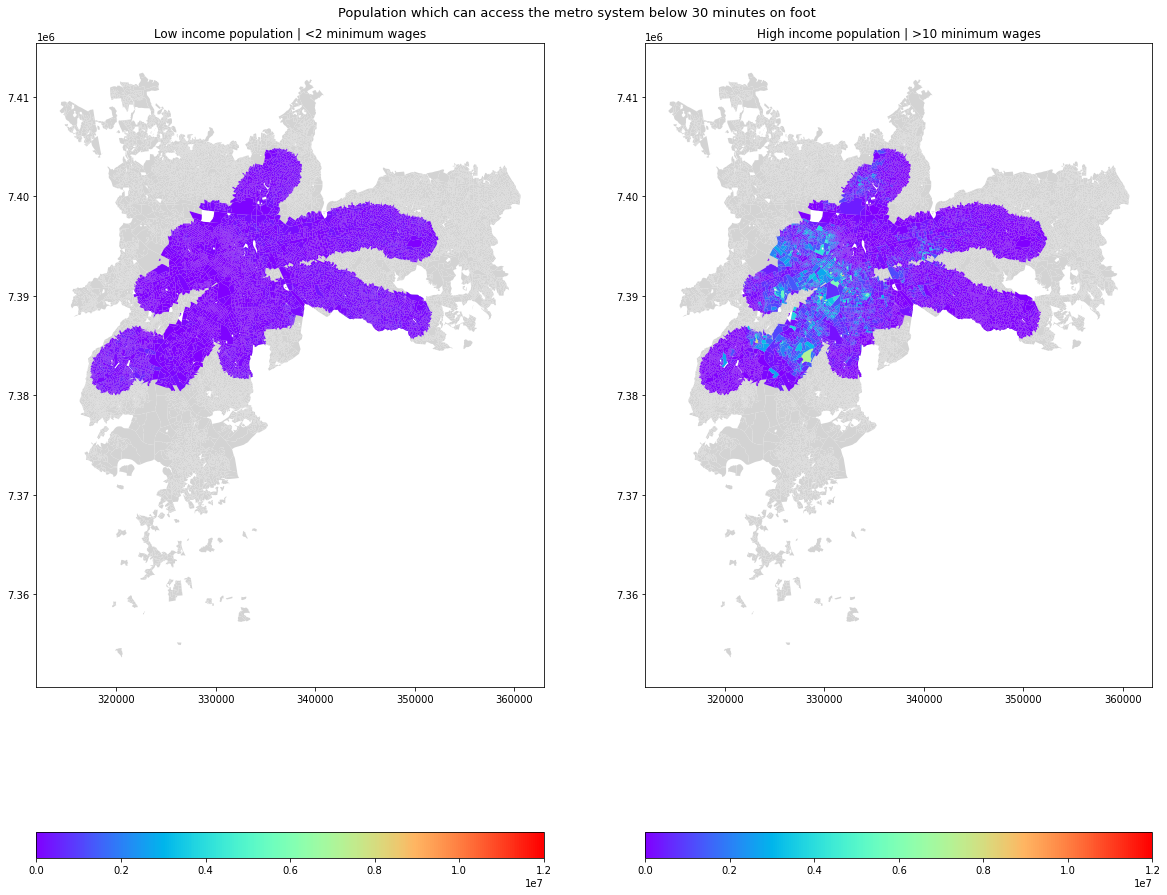

In [46]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

vmin=0
vmax=12000000

base1 = df_sample.plot(column='low_income', ax=ax[0], color='lightgrey')
base2 = df_sample.plot(column='high_income', ax=ax[1], color='lightgrey')

fig.subplots_adjust(top=0.8)
fig.suptitle("Population which can access the metro system below 30 minutes on foot", fontsize=13, y=0.80)

df_sample.loc[df_sample['below_30_minutes_on_foot'] == 1].plot(column='low_income', 
                                                               ax=base1, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)

df_sample.loc[df_sample['below_30_minutes_on_foot'] == 1].plot(column='high_income', 
                                                               ax=base2, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)
ax[0].set_title("Low income population | <2 minimum wages")
ax[1].set_title("High income population | >10 minimum wages")


plt.show()

We can clearly evaluate that when considering people which can access metro stations easily (up to 30 minutes on foot), we observe higher concentration of high income (>10 minimum wages) in those census sectors.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



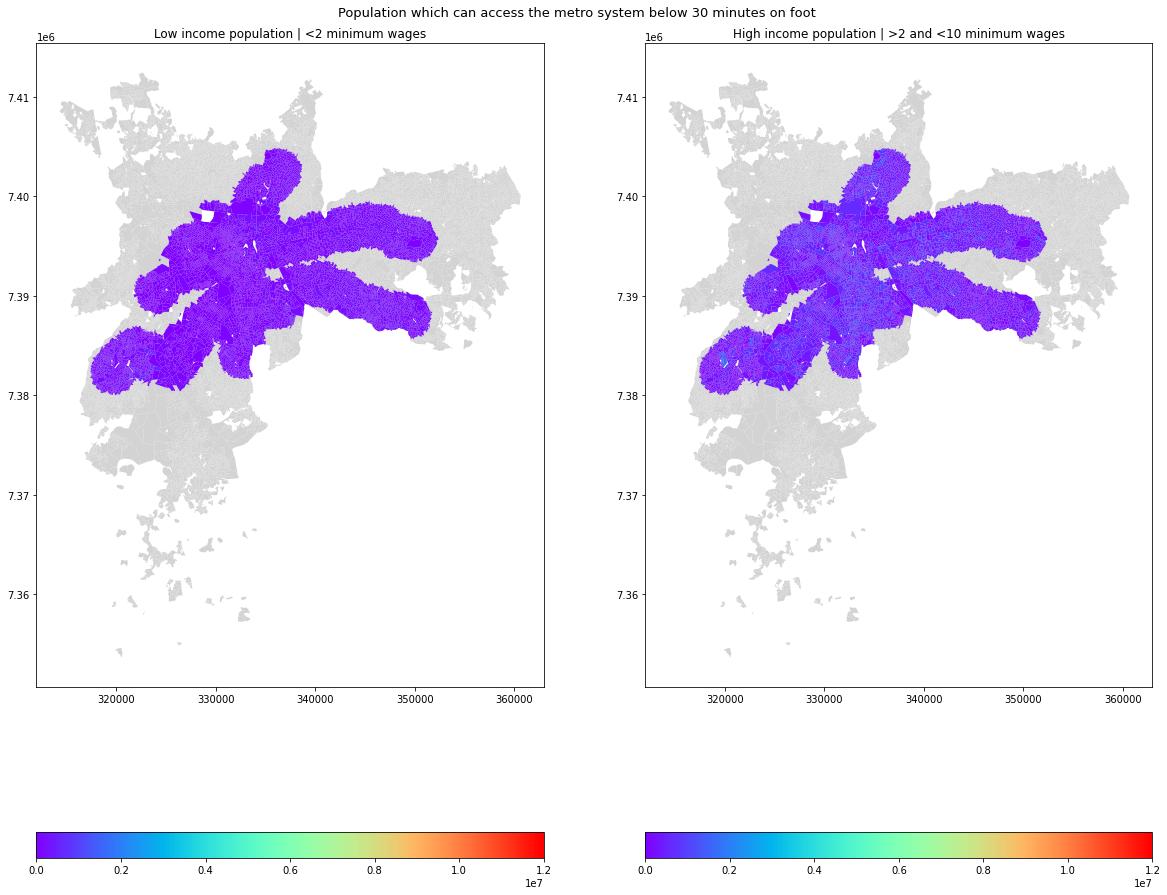

In [53]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

vmin=0
vmax=12000000

base1 = df_sample.plot(column='low_income', ax=ax[0], color='lightgrey')
base2 = df_sample.plot(column='medium_income', ax=ax[1], color='lightgrey')

fig.subplots_adjust(top=0.8)
fig.suptitle("Population which can access the metro system below 30 minutes on foot", fontsize=13, y=0.80)

df_sample.loc[df_sample['below_30_minutes_on_foot'] == 1].plot(column='low_income', 
                                                               ax=base1, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)

df_sample.loc[df_sample['below_30_minutes_on_foot'] == 1].plot(column='medium_income', 
                                                               ax=base2, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)
ax[0].set_title("Low income population | <2 minimum wages")
ax[1].set_title("Medium income population | >2 and <10 minimum wages")


plt.show()

The behavior is similar to the previows graph. There are more people inside those census sectors classified as medium income than low income.

# 2) People which can access subway above 5 km by income

In [48]:
df['above_5km'] = df['nearest_metro'].apply(lambda x: True if x > 5000 else False)
df['above_5km'] = df['above_5km'].astype(int)

In [49]:
df_sample2 = df[['geometry', 'above_5km', 'low_income', 'medium_income', 'high_income']]
print(df_sample2.shape)
df_sample2.head()

(17840, 5)


geometry  above_5km  low_income  \
4  POLYGON ((323845.814 7411697.682, 323855.562 7...          1        3918   
5  POLYGON ((324268.485 7411126.575, 324258.996 7...          1      193204   
6  POLYGON ((324252.505 7410983.620, 324253.811 7...          1        3150   
8  POLYGON ((340864.835 7410178.302, 340860.677 7...          1      120010   
9  POLYGON ((339956.973 7409553.043, 339959.737 7...          1      115030   

   medium_income  high_income  
4           5000            0  
5         153270            0  
6           6900        10000  
8          36250            0  
9         218000            0

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



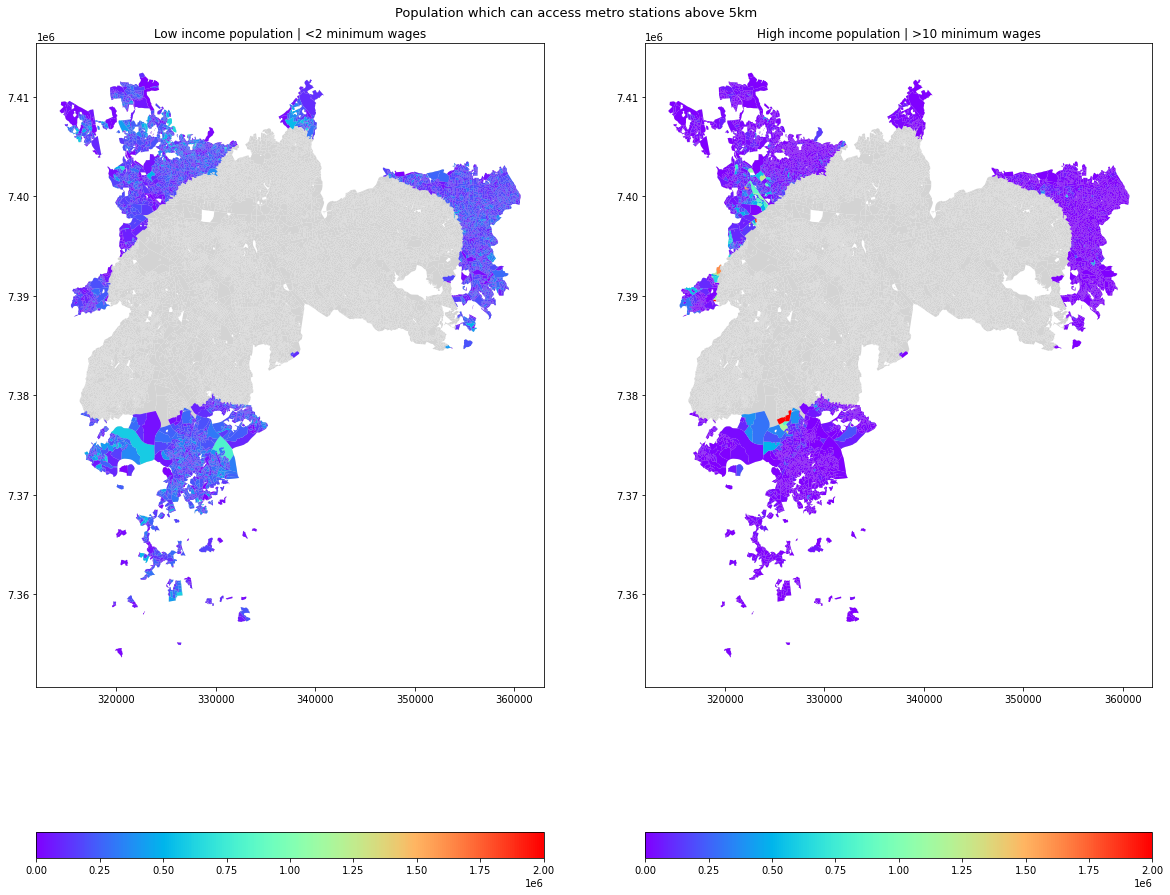

In [50]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

vmin=0
vmax=2000000

base1 = df_sample2.plot(column='low_income', ax=ax[0], color='lightgrey')
base2 = df_sample2.plot(column='high_income', ax=ax[1], color='lightgrey')

fig.subplots_adjust(top=0.8)
fig.suptitle("Population which can access metro stations above 5km", fontsize=13, y=0.80)

df_sample2.loc[df_sample2['above_5km'] == 1].plot(column='low_income', 
                                                               ax=base1, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)

df_sample2.loc[df_sample2['above_5km'] == 1].plot(column='high_income', 
                                                               ax=base2, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)
ax[0].set_title("Low income population | <2 minimum wages")
ax[1].set_title("High income population | >10 minimum wages")


plt.show()

We observe the inverted behavior when comparing it with the previows analysis. When considering regions which can access metro stations above 5 kilometers, the graph shows that there are more people with low income in those regions than higher income.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.

/usr/local/lib/python3.7/dist-packages/geopandas/plotting.py:642: UserWarning:

Only specify one of 'column' or 'color'. Using 'color'.



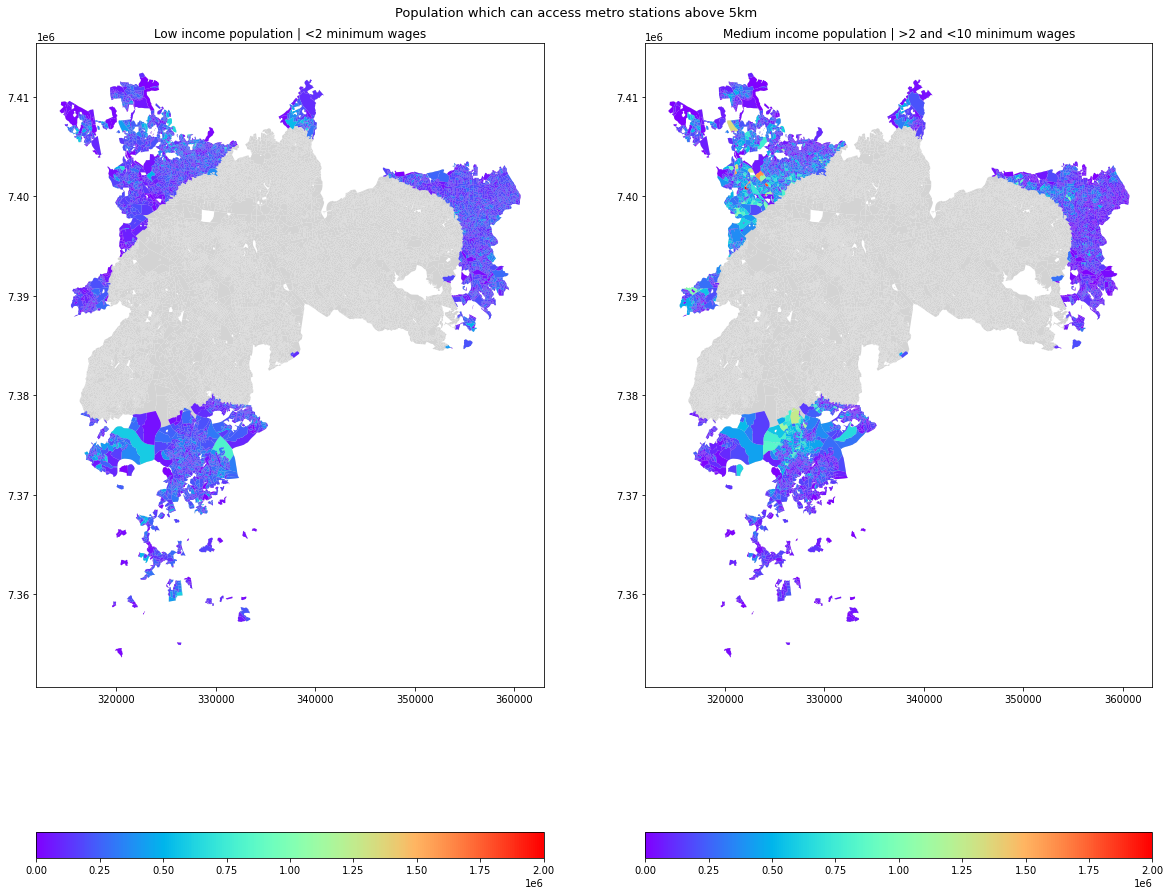

In [54]:
fig, ax = plt.subplots(1, 2, figsize=(20, 20))

vmin=0
vmax=2000000

base1 = df_sample2.plot(column='low_income', ax=ax[0], color='lightgrey')
base2 = df_sample2.plot(column='medium_income', ax=ax[1], color='lightgrey')

fig.subplots_adjust(top=0.8)
fig.suptitle("Population which can access metro stations above 5km", fontsize=13, y=0.80)

df_sample2.loc[df_sample2['above_5km'] == 1].plot(column='low_income', 
                                                               ax=base1, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)

df_sample2.loc[df_sample2['above_5km'] == 1].plot(column='medium_income', 
                                                               ax=base2, 
                                                               legend=True, 
                                                               legend_kwds={'orientation': 'horizontal'},
                                                               cmap = 'rainbow', vmin=vmin, vmax=vmax)
ax[0].set_title("Low income population | <2 minimum wages")
ax[1].set_title("Medium income population | >2 and <10 minimum wages")


plt.show()

Some census sectors of south and northwest of São Paulo showed high concentration of people with medium income in those regions.

# Conclusion

* In this notebook, we analysed data from the following data sources: IBGE and Geosampa. We used geolocation data and used the python library geopandas in order to analyse them.
* The main conclusion of the analysis is:

> **The accessibility of metro stations is directly related with income.** Other analysis could be done with train, bus, bicycle, etc which is available at Geosampa. Instead of income, it could be used age, sex, race and multiple other socioeconomical varibles avaliable at IBGE.

* Multiple data and variables were found in those data bases. Just  a few of them were used in this work as a sample of what is possible to do with this data and tools.
